In [6]:

!pip install kagglehub

In [7]:
import kagglehub

# Assuming kagglehub is a defined library/module
# If not, you'll need to install and import it correctly
# e.g., !pip install kaggle
# and then import the correct function

path = kagglehub.dataset_download("andrewmvd/bone-marrow-cell-classification") # Fixed syntax error: removed invalid unicode characters
print("Path to dataset files:", path) # Fixed syntax error: removed invalid unicode characters

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [9]:
data_dir = '/root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2'

In [10]:
print(os.listdir(data_dir))

['bone_marrow_cell_dataset', 'abbreviations.csv']


In [11]:
csv_path = os.path.join(data_dir, "abbreviations.csv")
df = pd.read_csv(csv_path)

print(df.head())

      Abbreviation;Meaning
0  ABE;Abnormal eosinophil
1             ART;Artefact
2             BAS;Basophil
3                BLA;Blast
4         EBO;Erythroblast


In [12]:
dataset_subfolder = os.path.join(data_dir, "bone_marrow_cell_dataset")
print(os.listdir(dataset_subfolder))


['BLA', 'LYI', 'NGS', 'MYB', 'PLM', 'MON', 'EBO', 'EOS', 'BAS', 'MMZ', 'FGC', 'HAC', 'PMO', 'NIF', 'LYT', 'ART', 'KSC', 'OTH', 'PEB', 'ABE', 'NGB']


In [13]:
image_dir = os.path.join(data_dir, "bone_marrow_cell_dataset")

image_paths = []
labels = []

# Looping through each class folder
for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, img_file)
            image_paths.append(image_path)
            labels.append(folder)

# DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})
print(data.head())


                                          image_path label
0  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA
1  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA
2  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA
3  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA
4  /root/.cache/kagglehub/datasets/andrewmvd/bone...   BLA


In [14]:
!pip install opencv-python-headless


In [18]:
import cv2

def load_and_resize_image(image_path, size=(224, 224)):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Image not found or invalid format: {image_path}")
            return None
        img = cv2.resize(img, size)
        img = img / 255.0
        return img
    except Exception as e:
        print(f"Error processing image: {image_path} - {e}")
        return None

# preprocessing to the DataFrame
data['image'] = data['image_path'].apply(load_and_resize_image)
data = data[data['image'].notnull()]
print(f"Total images after preprocessing: {len(data)}")


Total images after preprocessing: 1306


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# class labels to integers
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label'])

# Extracting image data and labels
X = np.stack(data['image'].values)
y = tf.keras.utils.to_categorical(data['encoded_label'].values)

# Spliting the dataset(80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)


Shapes:
X_train: (1044, 224, 224, 3) y_train: (1044, 7)
X_val: (262, 224, 224, 3) y_val: (262, 7)


In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load pre-trained MobileNetV2
prebuilt_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
prebuilt_model.trainable = False  # Freeze the base model to retain pretrained features

# Create a Sequential model and add custom layers
model_prebuilt = Sequential([
    prebuilt_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(y_train.shape[1], activation='softmax')  # Number of classes in output layer
])

# Compile the model
model_prebuilt.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model (adjust epochs and batch_size as needed)
history_prebuilt = model_prebuilt.fit(X_train, y_train,
                                      validation_data=(X_val, y_val),
                                      epochs=5,
                                      batch_size=32)


Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4022 - loss: 7.8603 - val_accuracy: 0.5763 - val_loss: 1.3057
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5412 - loss: 1.3962 - val_accuracy: 0.6183 - val_loss: 1.1574
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5882 - loss: 1.2448 - val_accuracy: 0.6679 - val_loss: 1.1248
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5954 - loss: 1.1364 - val_accuracy: 0.6908 - val_loss: 1.0700
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6356 - loss: 1.0186 - val_accuracy: 0.6565 - val_loss: 0.9572


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define custom CNN
model_custom = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_custom = model_custom.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.3454 - loss: 3.5819 - val_accuracy: 0.5534 - val_loss: 1.2930
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.4872 - loss: 1.2408 - val_accuracy: 0.4771 - val_loss: 1.2262
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.5471 - loss: 1.1584 - val_accuracy: 0.5305 - val_loss: 1.1629
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.5843 - loss: 1.0912 - val_accuracy: 0.6069 - val_loss: 1.0750
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6487 - loss: 0.9265 - val_accuracy: 0.5267 - val_loss: 1.1575


Evaluating Prebuilt Model
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


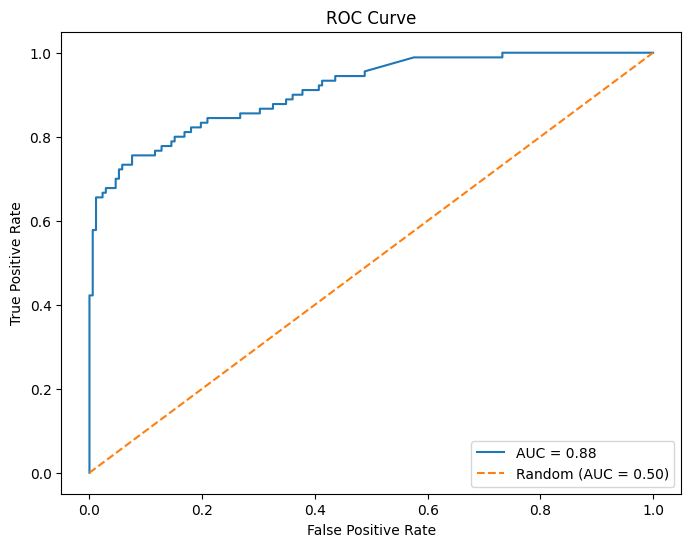

Evaluating Custom Model
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 894ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


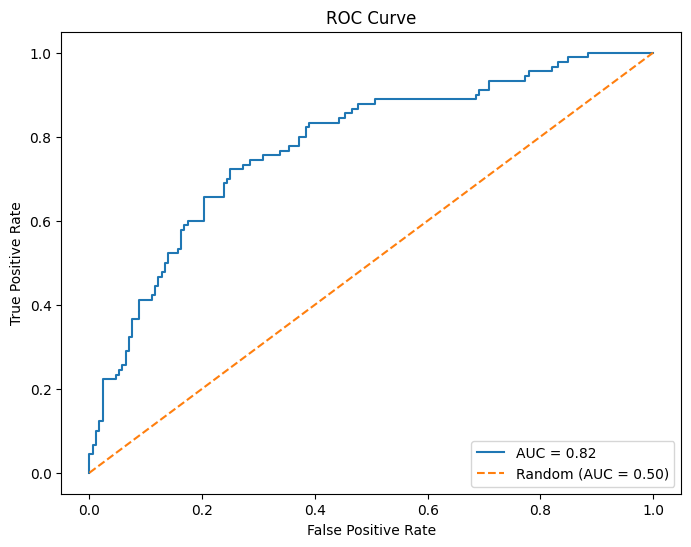


Comparison of Prebuilt and Custom Models:
           Prebuilt Model  Custom Model
accuracy              NaN           NaN
precision        0.656489      0.526718
recall           0.656489      0.526718
f1-score         0.656489      0.526718
AUC-ROC          0.881028      0.821848


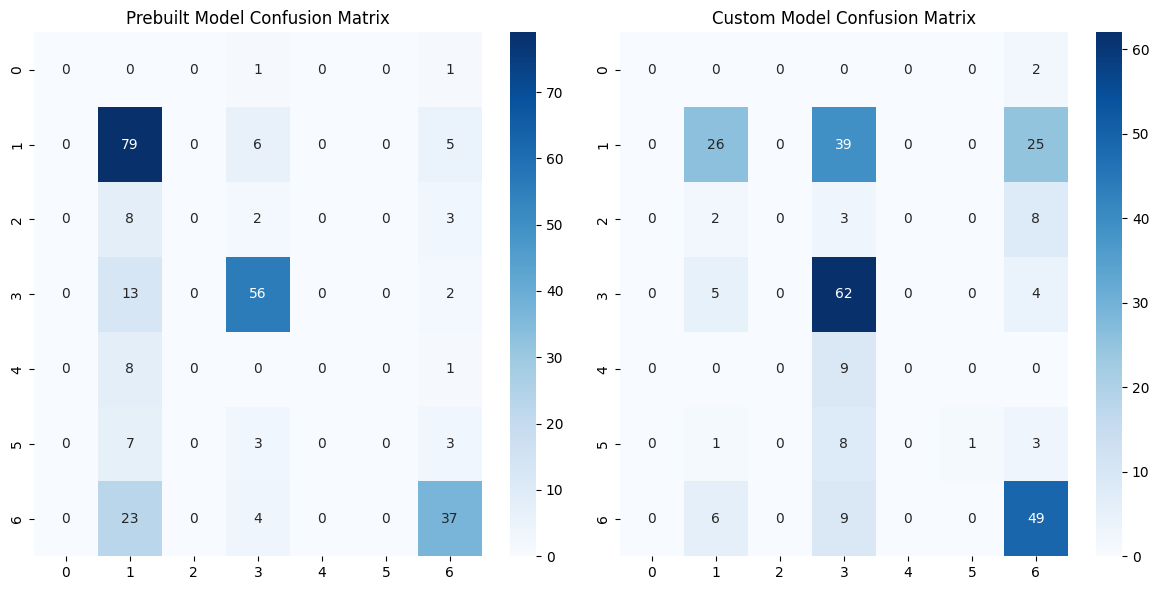

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


def get_metrics(model, X_val, y_val):
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)

    report = classification_report(y_true, y_pred, output_dict=True)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1], pos_label=1)  # For the first class (modify for others)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return report, cm, auc

print("Evaluating Prebuilt Model")
report_prebuilt, cm_prebuilt, auc_prebuilt = get_metrics(model_prebuilt, X_val, y_val)

print("Evaluating Custom Model")
report_custom, cm_custom, auc_custom = get_metrics(model_custom, X_val, y_val)

accuracy_prebuilt = report_prebuilt['accuracy']
accuracy_custom = report_custom['accuracy']

report_prebuilt_df = pd.DataFrame(report_prebuilt).transpose()
report_custom_df = pd.DataFrame(report_custom).transpose()

report_prebuilt_df.loc['accuracy'] = accuracy_prebuilt
report_custom_df.loc['accuracy'] = accuracy_custom

comparison_df = pd.DataFrame({
    'Prebuilt Model': report_prebuilt_df.loc['accuracy'],
    'Custom Model': report_custom_df.loc['accuracy']
}, index=['accuracy', 'precision', 'recall', 'f1-score'])

comparison_df.loc['AUC-ROC'] = [auc_prebuilt, auc_custom]

print("\nComparison of Prebuilt and Custom Models:")
print(comparison_df)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Prebuilt Confusion Matrix
sns.heatmap(cm_prebuilt, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Prebuilt Model Confusion Matrix')

# Custom Confusion Matrix
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Custom Model Confusion Matrix')

plt.tight_layout()
plt.show()
